In [1]:
from pathinit import *

import jax
import jax.numpy as jnp
import jax.scipy as jsc
from jax import grad, jit, vmap
from jax import jacfwd, jacrev, hessian
import jaxopt

from functools import partial

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 18

from jax.config import config
config.update("jax_enable_x64", True)

import scipy as sc
from scipy.optimize import minimize as sc_minimize
import scipy.stats as scs
import scipy.integrate as sc_integrate

#integration homemade
from CCquadInteg import *


#import seaborn as sns
#import pandas  as pd

2022-04-15 17:43:30.600927: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 
2022-04-15 17:43:30.878575: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 
2022-04-15 17:43:30.883173: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 


# Thème: Monte Carlo sampling.
en lien avec la note `JaxTutos/note-MCMC-Numpyro-Oct21.pdf` (French)

# Le cas du calcul d'une intégrale 1D

In [2]:
def prob(x, norm=1):
    return ((8/0.5)*jnp.exp(-0.5*(x/0.5)**2)+
                (2/0.1)*jnp.exp(-0.5*((x-1.5)/0.1)**2))/norm 

In [3]:
def phi(x):
    return x**2/8

# la librairie Scipy fournit une intégration numérique

In [5]:
Z = sc_integrate.quad(lambda x: prob(x),-3, 3)
Integ_true,err= sc_integrate.quad(lambda x: prob(x,norm=Z[0])*phi(x),-3, 3)
print("<phi>_true =",Integ_true,"+/-",err)

<phi>_true = 0.08149999825655681 +/- 4.063804085486462e-14


In [6]:
err/Integ_true

4.98626278824432e-13

### Au passage on peut utiliser le code d'intégration à base de la quadrature de Clenshaw-Curtis (`CCquadInteg.py`)

## Maintenant calculons la moyenne de $\phi(x)$ quand $x\sim p(x)$:
$$
\Large
E[\phi] = \int \phi(x)\ p(x) dx
$$

In [7]:
@jit
def f(x,norm=1):
    return phi(x)*prob(x,norm)

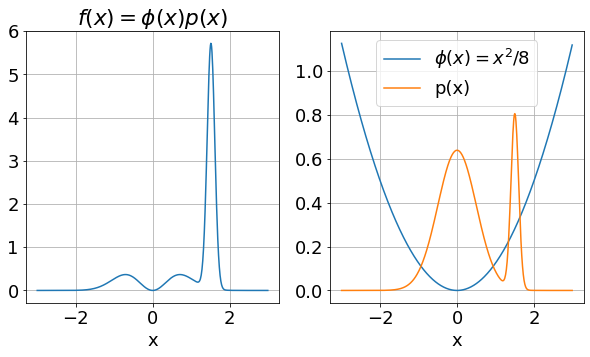

In [8]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
x = np.arange(-3,3,0.01)
axs[0].plot(x,f(x))
axs[0].set_xlabel("x")
axs[0].set_title("$f(x)=\phi(x) p(x)$")
axs[0].grid();
axs[1].plot(x,phi(x),label="$\phi(x)=x^2/8$")
axs[1].plot(x,prob(x,norm=Z[0]),label="p(x)")
axs[1].set_xlabel("x")
axs[1].legend()
axs[1].grid();

# Methode "moyenne" 

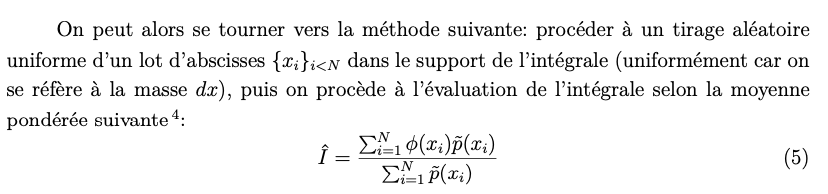

In [9]:
@partial(jit, static_argnums=(0,1))
def Integ0(N, f, subkey):
    xi = jax.random.uniform(subkey, (N,), minval=-3,maxval=3)
    Z_hat = jnp.sum(prob(xi))
    return jnp.sum(f(xi))/Z_hat

In [10]:
key = jax.random.PRNGKey(42)
Ns = [1000,10000,100000,1000000]
for n in Ns: 
    key, subkey = jax.random.split(key)
    I0 = Integ0(n,f,subkey)
    print(n,(I0-Integ_true)/Integ_true)

1000 -0.08168756632933909
10000 -0.014392879092519255
100000 0.005641294645926664
1000000 -0.0024126952481688616


In [174]:
key = jax.random.PRNGKey(20)
Ns = np.int32(np.logspace(3,7,50))
info =[]
for n in Ns: 
    key, subkey = jax.random.split(key)
    I0 =  Integ0(n,f,subkey)
    info.append(I0)

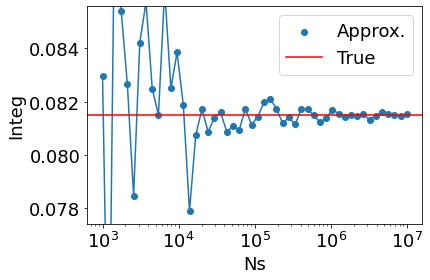

In [175]:
plt.scatter(Ns,np.array(info),label='Approx.')
plt.plot(Ns,np.array(info))
plt.axhline(y=Integ_true, color='r', linestyle='-',label='True')
plt.xscale('log')
plt.xlabel('Ns')
plt.ylabel('Integ')
plt.ylim([Integ_true*0.95,Integ_true*1.05])
plt.legend()
plt.show()

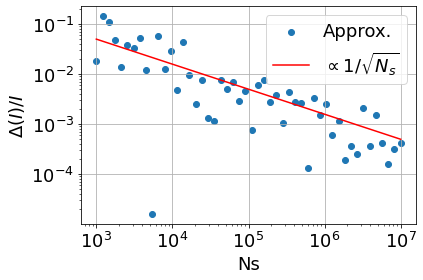

In [176]:
plt.scatter(Ns,np.abs(np.array(info)-Integ_true)/Integ_true,label='Approx.')
#plt.plot(Ns,np.abs(np.array(info)-Integ_true)/Integ_true)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Ns')
plt.ylabel('$\Delta(I)/I$')
plt.plot(Ns,0.035*np.sqrt(2e3/Ns),label='$\propto 1/\sqrt{N_s}$',c='r')
plt.grid()
plt.legend()
plt.show()

## Notez bien la dépendance $1/\sqrt{N}$

In [177]:
print(f"Ns       err. relat.")
for n in range(3,7):
    cut = (10**n<=Ns) & (Ns<10**(n+1))
    print(f"{np.mean(Ns[cut]):7.0f}\
 {(np.mean(np.array(info)[cut])-Integ_true)/Integ_true:15.6e}")

Ns       err. relat.
   3910    1.594260e-02
  39628   -6.282093e-03
 378099    5.583642e-04
3607432    9.038853e-05


In [178]:
quad = ClenshawCurtisQuad(100) # 200pts
Z = quadIntegral(lambda x: prob(x), -3,3, quad)
Integ_cc=quadIntegral(lambda x: prob(x,norm=Z)*phi(x),-3,3, quad)
print("Diff relat. avec scipy: ",(Integ_cc-Integ_true)/Integ_true)

Diff relat. avec scipy:  -3.405592172929394e-16


# Importance Sampling

L'idée est de générer des échantillons aléatroires selon une distribution $q(x)$ laquelle est une approximation de $p(x)$ (on note avec un $\tilde{}$ la distribution non-normalisée)

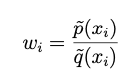
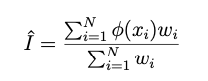
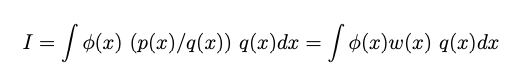

Le choix de $q(x)$ va conditionner la performance de cet algorithme.

## Ci-dessous 2 types d'approxiamtions à base de gaussiennes

In [231]:
scale_0 = 3
def qapp0(x):
    return 90*jax.scipy.stats.norm.pdf(x,scale=scale_0)

In [232]:
scale_1 = 0.5
mean_1  = 1.5
def qapp(x):
    return 20*(jax.scipy.stats.norm.pdf(x,scale=scale_1)+\
            jax.scipy.stats.norm.pdf(x-mean_1,scale=scale_1))

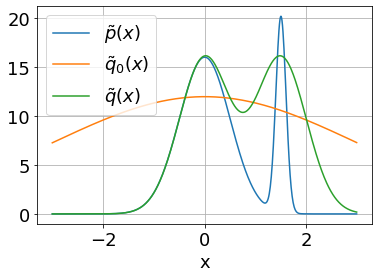

In [233]:
x = np.arange(-3,3,0.01)
plt.plot(x,prob(x), label=r"$\tilde{p}(x)$")
plt.plot(x,qapp0(x), label=r'$\tilde{q}_0(x)$')
plt.plot(x,qapp(x), label=r'$\tilde{q}(x)$')
plt.grid()
plt.legend()
plt.xlabel("x");

Si la génération de nombre aléatoire avec 1 gaussienne directement implémentée dans les librairy, voici une génération simple d'une distribution somme de 2 gaussiennes.

In [234]:
key, subkey1,subkey2  = jax.random.split(jax.random.PRNGKey(42),3)
xs1 = jax.random.normal(subkey1, (10000,))*scale_1
xs2 = jax.random.normal(subkey2, (10000,))*scale_1+mean_1
xs  = jnp.concatenate([xs1,xs2])

In [235]:
quad = ClenshawCurtisQuad(100)
Zq = quadIntegral(lambda x: qapp(x),-5, 5, quad) 

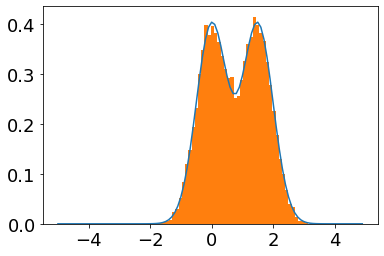

In [236]:
xi = np.arange(-5,5,0.1)
plt.plot(xi,qapp(xi)/Zq)
plt.hist(np.array(xs),bins=50,density=True); 
# hist n'aime pas les devic array de Jax/Lax mais la conversion en np.ndarray est immediate

In [238]:
@partial(jit, static_argnums=1)
def importance_sampling(key,N):
    key, subkey = jax.random.split(key)
    xs1= jax.random.normal(subkey, (N//2,))*scale_1
    xs2= jax.random.normal(subkey, (N//2,))*scale_1 + mean_1
    x_Qrnd=jnp.concatenate([xs1,xs2])
    w = prob(x_Qrnd)/qapp(x_Qrnd)
    norm = jnp.sum(w)
    phi_samples=phi(x_Qrnd)
    integ = jnp.dot(w/norm,phi_samples)
    return integ,w, key

@partial(jit, static_argnums=1)
def importance_sampling_0(key,N):
    key, subkey = jax.random.split(key)
    x_Qrnd=jax.random.normal(subkey, (N,))*scale_0
    w = prob(x_Qrnd)/qapp0(x_Qrnd)
    norm = jnp.sum(w)
    phi_samples=phi(x_Qrnd)
    integ = jnp.dot(w/norm,phi_samples)
    return integ,w, key

In [239]:
Integ_is,Ws0,_= importance_sampling_0(key,100000)
print(f"$I_{{is}}^0$ = {Integ_is:.6e};  \trelat. err ={np.abs(Integ_is-Integ_true)/Integ_true:.6e}")

Integ_is,Ws,_= importance_sampling(key,100000)
print(f"$I_{{is}}$ = {Integ_is:.6e};  \trelat. err ={np.abs(Integ_is-Integ_true)/Integ_true:.6e}")

$I_{is}^0$ = 8.142562e-02;  	relat. err =9.125766e-04
$I_{is}$ = 8.159547e-02;  	relat. err =1.171418e-03


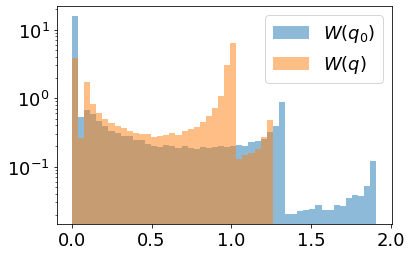

In [240]:
_,bins,_=plt.hist(np.array(Ws0),bins=50,alpha=0.5,density=True,label='$W(q_0)$');
plt.hist(np.array(Ws),bins=bins,alpha=0.5,density=True,label='$W(q)$');
plt.yscale('log')
plt.legend();

In [241]:
key = jax.random.PRNGKey(20)
Ns = np.int32(np.logspace(3,7,20))
infoI1_0 =[]
infoI1 =[]
for n in Ns: 
    I1_0,_,key =  importance_sampling_0(key,n)
    I1,_,key =  importance_sampling(key,n)
    infoI1_0.append(I1_0)
    infoI1.append(I1)

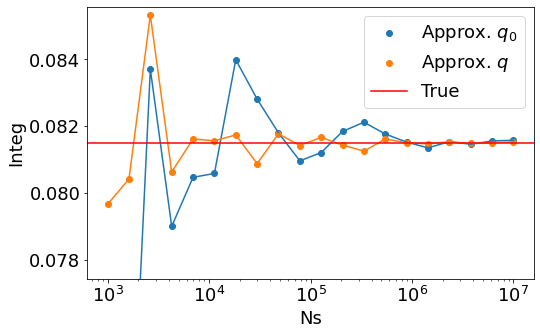

In [243]:
fig,_=plt.subplots(figsize=(8,5))
plt.scatter(Ns,np.array(infoI1_0),label='Approx. $q_0$')
plt.plot(Ns,np.array(infoI1_0))
plt.scatter(Ns,np.array(infoI1),label='Approx. $q$')
plt.plot(Ns,np.array(infoI1))
plt.axhline(y=Integ_true, color='r', linestyle='-',label='True')
plt.xscale('log')
plt.xlabel('Ns')
plt.ylabel('Integ')
plt.ylim([Integ_true*0.95,Integ_true*1.05])
plt.legend()
plt.show()

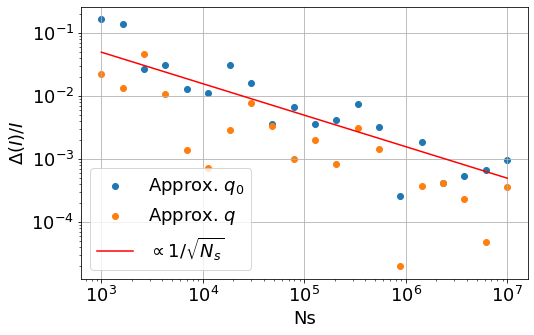

In [244]:
fig,_=plt.subplots(figsize=(8,5))
plt.scatter(Ns,np.abs(np.array(infoI1_0)-Integ_true)/Integ_true,label='Approx. $q_0$')
plt.scatter(Ns,np.abs(np.array(infoI1)-Integ_true)/Integ_true,label='Approx. $q$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Ns')
plt.ylabel('$\Delta(I)/I$')
plt.plot(Ns,0.035*np.sqrt(2e3/Ns),label='$\propto 1/\sqrt{N_s}$',c='r')
plt.grid()
plt.legend()
plt.show()

In [245]:
print(f"Ns       err. relat. q_0   err. relat. q")
for n in range(3,7):
    cut = (10**n<=Ns) & (Ns<10**(n+1))
    print(f"{np.mean(Ns[cut]):7.0f}\
 {(np.mean(np.array(infoI1_0)[cut])-Integ_true)/Integ_true:15.6e}\
  {(np.mean(np.array(infoI1)[cut])-Integ_true)/Integ_true:15.6e}"
         )

Ns       err. relat. q_0   err. relat. q
   3298   -6.398933e-02     3.354881e-04
  37237    6.475739e-03    -3.460517e-04
 420349    2.333749e-03    -9.331659e-05
3431336   -3.256506e-04    -3.602916e-05


## **moralité**: plus on a une approximation $q(x)$ "bonne" de $p(x)$ meilleure est le calcul de l'intégrale, c'est-à-dire le sampling de $p(x)$. Cela se traduit en fait sur la distribution des poids qui au mieux doit se concentrer autour de $1$. Mais cela devient très improbable en grande dimension. Voir l'exo suivant.

# En dimension N>1
## Plus $N$ augmente plus les méthodes par intégration numérique classiques (ex. quadrature) ne peuvent être mises en pratique.

## Soit la loi uniforme dans une boule de rayon $R$ en dimension $d$

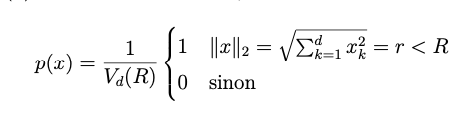

## on veut calculer par *importance samping* l'intégrale suivante 
$$
\Large
I(d) = \int r^2 p(x) dx^d = R^2 \frac{d}{d+1}
$$



## Exo: coder la fonction $p(x)$
```python
@jit
def prob_nD(x,R=1):
    res = ...
    return res
```
*hint*: rappelez vous que l'on a pas besoin de connaître la normalisation.

In [246]:
@jit
def prob_nD(x,R=1):
    r  = jnp.linalg.norm(x,axis=1)
    return jnp.where(r<R,1,0)

## On va se servir comme approximation de la loi normale centrée en dimension $d$
$$
\Large
q(x) = \mathcal{N}_d(0,\sigma^2) = \frac{e^{-x^2/(2\sigma^2)}}{(2\pi\sigma^2)^{d/2}}
$$

In [254]:
@jit
def qapp_nD(x,s=1):
    dim = x.shape[1]
    return jax.scipy.stats.multivariate_normal.pdf(x,np.zeros(dim), s**2*np.identity(dim))

Où sont localisés les points tirées selon une loi gaussienne en dimension $d$?
$$
\Large
\langle r \rangle =  \langle \sqrt{\|x\|^2} \rangle = \sigma \sqrt{d}; \qquad \sigma_r = \frac{\sigma}{\sqrt{2}}
$$

In [255]:
key = jax.random.PRNGKey(0)
N=10_000
dims = jnp.array([10,20,50,100,200,500,1000])
s=1
info1 = []
info2 = []
for dim in dims:
    key, subkey = jax.random.split(key)
    data = jax.random.multivariate_normal(subkey,
                                        np.zeros(dim),
                                        s**2*np.identity(dim),
                                        (N,))
    r = jnp.linalg.norm(data,axis=1)
    info1.append(jnp.mean(r))
    info2.append(jnp.std(r))

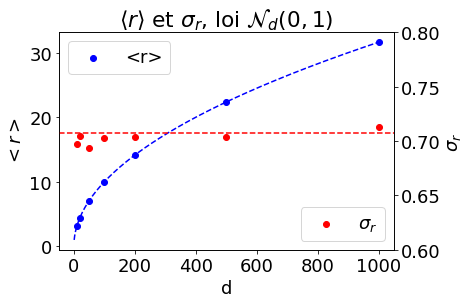

In [258]:
fig, ax = plt.subplots()
axes = [ax, ax.twinx()]
axes[0].scatter(dims,info1,c='b',label="<r>");
xi = np.arange(1,1000,0.1)
axes[0].plot(xi,np.sqrt(xi),c='b',ls="--")
axes[0].set_xlabel("d")
axes[0].set_ylabel("$<r>$")
axes[1].scatter(dims,info2,c='r',label="$\sigma_r$");
axes[1].axhline(y=1/np.sqrt(2), color='r', linestyle='--')
axes[1].set_ylim([0.6,0.8])
axes[1].set_ylabel("$\sigma_r$")
plt.title(r"$\langle r \rangle$ et $\sigma_r$, loi $\mathcal{N}_d(0,1)$");
axes[0].legend(loc='upper left');
axes[1].legend(loc="lower right");

## Donc en dimension $d$ les points générés par une gaussienne centrée, contrairement à l'intuition, se concentre non pas autour de l'origine mais sur une coquille de rayon $\langle r\rangle = \sigma d^{1/2}$ dont l'épaisseur est une constante $\sigma_r$. Donc, pour que les poids $p(x_i)/q(x_i)$ ne soient pas nuls ou infinis il faut que $\langle r\rangle\leq R$ c'est-à-dire $\sigma\leq R/\sqrt{d}$ 

In [259]:
@jit
def phi_nD(x):
    r  = jnp.linalg.norm(x,axis=1)
    return r*r

In [260]:
@partial(jit, static_argnums=(1,2))
def importance_sampling_nD(key,N,dim=2,R=1,s=1):
    key, subkey = jax.random.split(key)
    x_Qrnd = jax.random.multivariate_normal(subkey,
                                            np.zeros(dim),
                                            s**2*np.identity(dim),
                                            (N,))
    
    w = prob_nD(x_Qrnd,R)/qapp_nD(x_Qrnd,s)
    norm = jnp.sum(w)
    w /= norm
    phi_samples=phi_nD(x_Qrnd)
    integ = jnp.dot(w,phi_samples)
    return key,integ,w

In [261]:
def integ_true_nD(dim,R=1):
    return R**2*dim/(dim+2)

In [403]:
key = jax.random.PRNGKey(50)
Ns = 100_000
dim = 400
R = 1
facteur=1.0
sigma =  facteur  * R/np.sqrt(dim)
_,integ_is,w = importance_sampling_nD(key,Ns,dim=dim,R=R,s=sigma)
I_true =  integ_true_nD(dim,R)
print(f"Integ= {integ_is:.6}, True={I_true:.6}, err relat.={(integ_is-I_true)/I_true:.2e}" )
w_max = jnp.max(w)
w_med = jnp.median(w)
print(f"w max: {w_max:.6e}, med: {w_med:.6e}, max/med: {w_max/w_med:.6e}")

Integ= 0.994978, True=0.995025, err relat.=-4.74e-05
w max: 3.594770e-04, med: 2.448502e-18, max/med: 1.468151e+14


## Exo: changer le facteur pour  {0.8,1.17561336}

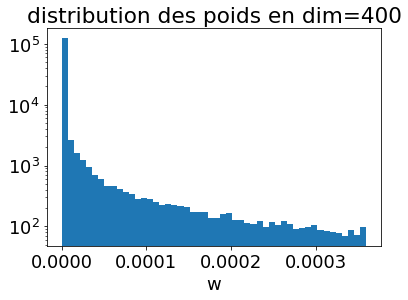

In [404]:
plt.hist(np.array(w),bins=50,density=True);
plt.yscale('log')
plt.title(f"distribution des poids en dim={dim}")
plt.xlabel("w");

## la distribution des poids est tres piquée à petit $w$ et le rapport $w_{max}/w_{med}$ explose

In [333]:
def test(dim):
    key = jax.random.PRNGKey(0)
    Ns = 10_000
    R = 1
    sigma = R/jnp.sqrt(dim)
    _,integ,w = importance_sampling_nD(key,Ns,dim=dim,R=R,s=sigma)
    w_max = jnp.max(w)
    w_med = jnp.median(w)
    return integ,w_max/w_med

In [334]:
dims = np.array([1,2,5,10,20,30,40,50,100,200,300,400])

In [335]:
info = []
for d in dims:
    _,val = test(d)
    info.append(val)

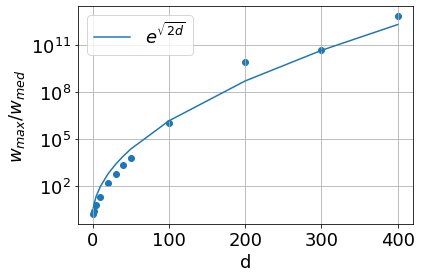

In [336]:
plt.scatter(dims,info)
plt.yscale('log')
plt.plot(dims,np.exp(np.sqrt(2*dims)),label="$e^{\sqrt{2d}}$")
plt.xlabel("d")
plt.ylabel("$w_{max}/w_{med}$")
plt.grid()
plt.legend()
plt.show()

# le calcul de l'intégrale est déterminée par une distribution de poids qui n'a rien de centrée sur $1$ et devient très sensible aux poids dans la  queue de distribution.

# Metropolis-Hastings method
(C. Metropolis (1915-99) et Wilfred Hastings (1930-2016))

## La méthode date des années 1950-70. Dans l'Importance Sampling $q(x)$ est choisie une fois pour toute. **M-H va générer des échantillons (constituant une chaine de Markov) où $q(x)$ va être adaptée à chaque titage**.

Pour générer un échantillon à l'étape $i$, noté $x_i$:
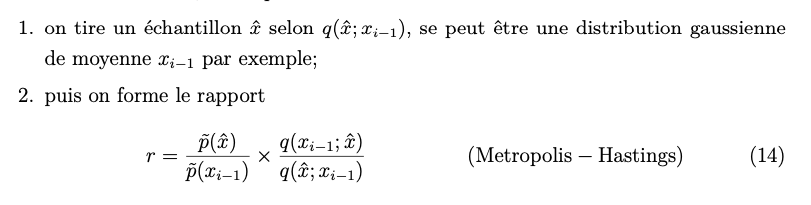

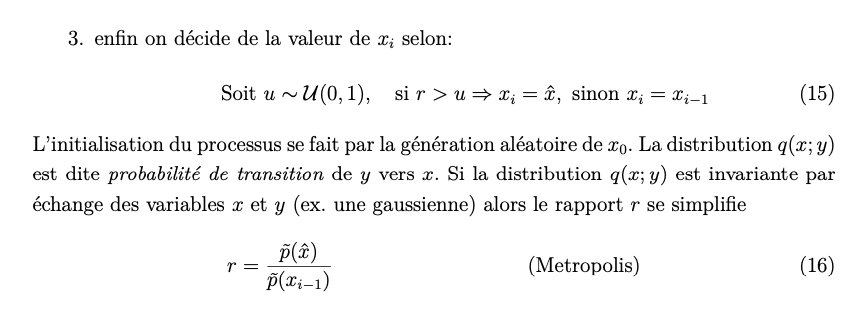


## Simple cas en 1D, multi-chaines (Numpy)

In [319]:
class MixtureModel(scs.rv_continuous):
    def __init__(self, submodels, weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.submodels = submodels
        weights   = np.array(weights)
        norm = np.sum(weights)
        self.weights = weights/norm
        self.num_distr = len(submodels)
        #print(self.num_distr, self.weights,self.submodels)
        

    def _pdf(self, x):
        pdf = 0.
        for i, submodel in enumerate(self.submodels):
            pdf += self.weights[i]*submodel.pdf(x)
            
        return pdf

    # Random generation to compare with Metropolis sampling
    def rvs(self, sample_size):
        random_idx = np.random.choice(np.arange(self.num_distr), size=(sample_size,), p=self.weights)
        submodel_samples = [submodel.rvs(size=sample_size) for submodel in self.submodels]
        print(np.array(submodel_samples).shape)
        rvs = np.choose(random_idx, submodel_samples)
        return rvs

In [320]:
# somme de 2 gaussiennes
mixture_gaussian_model = MixtureModel([scs.norm(loc=0, scale=0.5), 
                                       scs.norm(loc=1.5, scale=0.2)],
                                      [8,2])

In [321]:
def phi(x):
    return x**2

## 

In [322]:
def MHSampling_v2p(proba,Ns=100_000,Nchain=10,scale=0.1, forget=25_000):
    # Ns nbre de samples per chain
    samples = []
    # forget a fixed number of samples for each chain
    Ns = Ns + forget
    current = scs.uniform.rvs(loc=-3,scale=6, size=(Nchain,))
    for i in range(Ns):
        samples.append(current.copy())
        #proposal in [current-scale,current+scale]
        proposal = scs.uniform.rvs(loc=current-scale,scale=2*scale, size=(Nchain,))
        # proposal distrib is symetric: q(x_c,x_p)=q(x_c-x_p)=q(x_p,x_c)
        r = proba(proposal)/proba(current)  
        u = scs.uniform.rvs(size=(Nchain,))
        mask = r>u #accept proposal
        current[mask] = proposal[mask]

    #return all chains with the first "forget" samples rejected
    samples = np.array(samples).T
    return samples[:,forget:]

In [323]:
spls = MHSampling_v2p(lambda x: mixture_gaussian_model.pdf(x),
                            Ns=100_000, Nchain=100, forget=25000, scale=0.1
                           )

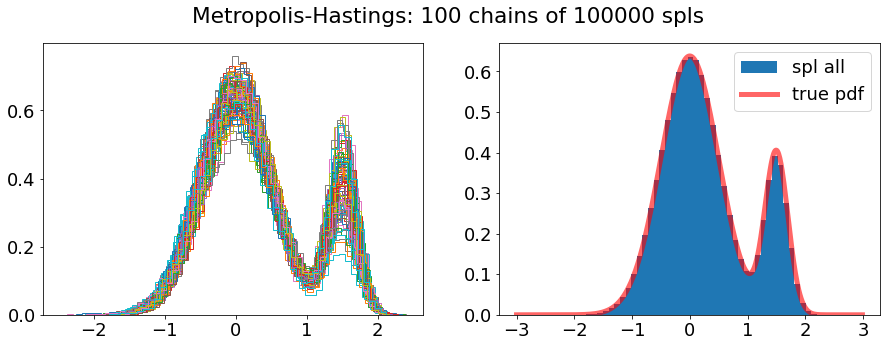

In [324]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
for i in range(spls.shape[0]):
    axs[0].hist(spls[i],bins=50, density=True, histtype='step',label=f"spl [{i}]");
#axs[0].plot(x_axis, mixture_gaussian_model.pdf(x_axis),'r-', lw=5, alpha=0.6, label='true pdf')
#axs[0].legend(loc='upper right')
#
axs[1].hist(spls.flatten(),bins=50, density=True,label=f"spl all");
x_axis = np.arange(-3, 3, 0.01)
axs[1].plot(x_axis, mixture_gaussian_model.pdf(x_axis),'r-', lw=5, alpha=0.6, label='true pdf')
axs[1].legend()
fig.suptitle(f"Metropolis-Hastings: {spls.shape[0]} chains of {spls.shape[1]} spls")

plt.show()

In [1239]:
spl_all= spls.flatten()
phi_spl = phi(spl_all)
Integ_M = np.mean(phi_spl)

In [1240]:
print(f"Integ ({spl_all.shape[0]:.0e} spl): {Integ_M:.6e}")

Integ (1e+07 spl): 6.580126e-01


In [1234]:
Integ_true,_=integrate.quad(lambda x: phi(x)*mixture_gaussian_model.pdf(x),-3,3)

In [1236]:
Integ_true

0.6579999850231879

In [1243]:
(Integ_M-Integ_true)/Integ_true

1.918786659422559e-05

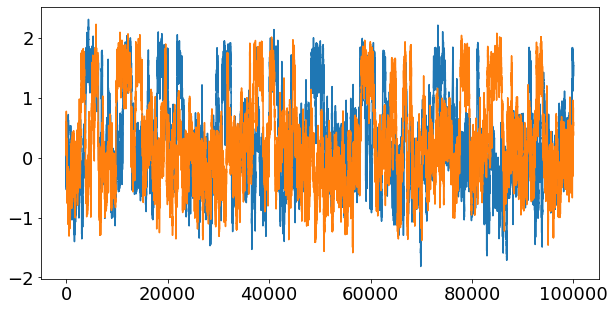

In [1221]:
fig = plt.figure(figsize=(10,5))
plt.plot(spls[0])
plt.plot(spls[1])

## Version avec les logprob et implementee en Jax

In [2]:
class MixtureModel_jax():
    def __init__(self, locs, scales, weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loc = jnp.array([locs]).T
        self.scale = jnp.array([scales]).T
        self.weights = jnp.array([weights]).T
        norm = jnp.sum(self.weights)
        self.weights = self.weights/norm

        self.num_distr = len(locs)

    def pdf(self, x):
        probs = jax.scipy.stats.norm.pdf(x,loc=self.loc, scale=self.scale)
        return jnp.dot(self.weights.T,probs).squeeze()
        
    def logpdf(self, x):
        log_probs = jax.scipy.stats.norm.logpdf(x,loc=self.loc, scale=self.scale)
        return jax.scipy.special.logsumexp(jnp.log(self.weights) + log_probs, axis=0)

In [247]:
mixture_gaussian_model = MixtureModel_jax([0,1.5],[0.5,0.1],[8,2])

In [4]:
@partial(jax.jit, static_argnums=(1,))
def jax_metropolis_kernel(rng_key, logpdf, position, log_prob):
    key, subkey = jax.random.split(rng_key)
    """Moves the chain by one step using the Random Walk Metropolis algorithm.
  
    Attributes
    ----------
    rng_key: jax.random.PRNGKey
      Key for the pseudo random number generator.
    logpdf: function
      Returns the log-probability of the model given a position.
    position: np.ndarray, shape (n_dims,)
      The starting position.
    log_prob: float
      The log probability at the starting position.

    Returns
    -------
    Tuple
        The next positions of the chains along with their log probability.
    """
    move_proposals = jax.random.normal(key, shape=position.shape) * 0.1
    proposal = position + move_proposals
    proposal_log_prob = logpdf(proposal)

    log_uniform = jnp.log(jax.random.uniform(subkey))
    do_accept = log_uniform < proposal_log_prob - log_prob

    position = jnp.where(do_accept, proposal, position)
    log_prob = jnp.where(do_accept, proposal_log_prob, log_prob)
    return position, log_prob

@partial(jax.jit, static_argnums=(1, 2))
def jax_metropolis_sampler(rng_key, n_samples, logpdf, initial_position):
    """Generate samples using the Random Walk Metropolis algorithm.
    Attributes
    ----------
    rng_key: jax.random.PRNGKey
        Key for the pseudo random number generator.
    n_samples: int
        Number of samples to generate per chain.
    logpdf: function
      Returns the log-probability of the model given a position.
    inital_position: np.ndarray (n_dims, n_chains)
      The starting position.
    Returns
    -------
    (n_samples, n_dim)
    """
    def mh_update(i, state):
        key, positions, log_prob = state
        _, key = jax.random.split(key)
        new_position, new_log_prob = jax_metropolis_kernel(key, 
                                                           logpdf, 
                                                           positions[i-1], 
                                                           log_prob)
        positions=positions.at[i].set(new_position)
        return (key, positions, new_log_prob)


    logp = logpdf(initial_position)
    # all positions structure should be set before lax.fori_loop
    
    all_positions = jnp.zeros((n_samples,initial_position.shape[0]))  # 1 chain for each vmap call
    
    initial_state = (rng_key,all_positions, logp)
    rng_key, all_positions, log_prob = jax.lax.fori_loop(1, n_samples, 
                                                 mh_update, 
                                                 initial_state)
    
    
    return all_positions

In [10]:
n_dim = 1
n_forget = 25_000
n_samples = 100_000 + n_forget
n_chains = 1_000

rng_key = jax.random.PRNGKey(42)

rng_keys = jax.random.split(rng_key, n_chains)
initial_position = jnp.zeros((n_dim, n_chains))

run_mcmc = jax.vmap(jax_metropolis_sampler, 
                    in_axes=(0, None, None, 1),
                    out_axes=0)
all_positions = run_mcmc(rng_keys, n_samples, 
                     lambda x: mixture_gaussian_model.logpdf(x), 
                     initial_position)

all_positions = all_positions.squeeze()

all_positions=np.asarray(all_positions[:,25_000:])

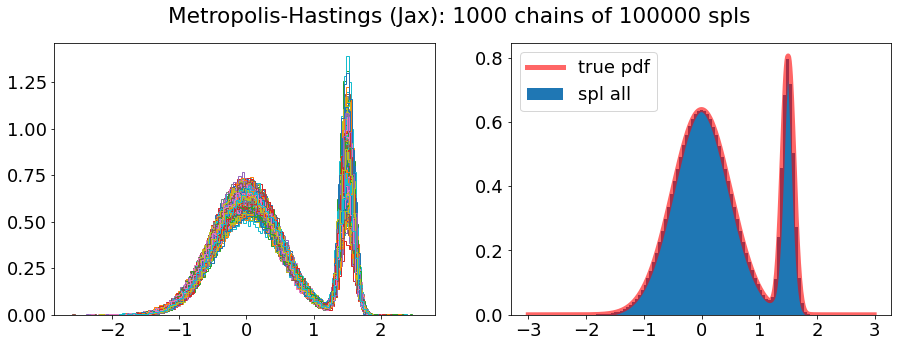

In [11]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
for i in range(all_positions.shape[0]):
    axs[0].hist(all_positions[i],bins=100, density=True, histtype='step',label=f"spl [{i}]");
#axs[0].plot(x_axis, mixture_gaussian_model.pdf(x_axis),'r-', lw=5, alpha=0.6, label='true pdf')
#axs[0].legend(loc='upper right')
#
axs[1].hist(all_positions.flatten(),bins=100, density=True,label=f"spl all");
x_axis = np.arange(-3, 3, 0.01)
axs[1].plot(x_axis, mixture_gaussian_model.pdf(x_axis),'r-', lw=5, alpha=0.6, label='true pdf')
axs[1].legend()
fig.suptitle(f"Metropolis-Hastings (Jax): {all_positions.shape[0]} chains of {all_positions.shape[1]} spls")

plt.show()

## Estimation de  parametres: 3 dim

In [2]:
sample_size = 5_000
sigma_e = 1.5             # true value of parameter error sigma
random_num_generator = np.random.RandomState(0)
xi = 10.0 * random_num_generator.rand(sample_size)
e = random_num_generator.normal(0, sigma_e, sample_size)
yi = 1.0 + 2.0 * xi +  e          # a = 1.0; b = 2.0; y = a + b*x

In [3]:
def lik(parameters, X, Y):
    m = parameters[1]
    b = parameters[0]
    sigma = parameters[2]
    y_exp = m * X + b
    L = len(X)/2 * np.log(2 * np.pi * sigma ** 2) \
         + 1/(2 * sigma ** 2) * sum((Y - y_exp) ** 2)
    return L

In [4]:

lik_model = minimize(lik, np.array([1,1,1]), args=(xi,yi), method='L-BFGS-B')
print(lik_model['x'])

[0.98725158 1.99939789 1.47958158]


In [5]:
mini=lik_model['x']
df_mini = pd.DataFrame(mini[np.newaxis,:],columns=["bias","slope","sigma"])
df_mini["chain"]="Min Scipy"

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


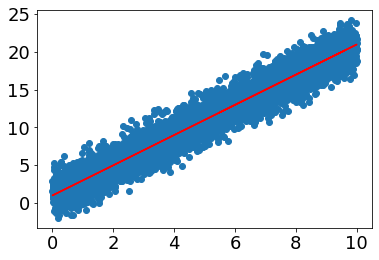

In [6]:
plt.scatter(xi,yi)
plt.plot(xi, lik_model['x'][1] * xi + lik_model['x'][0],c='r')
plt.show()

In [435]:
def jax_metropolis_kernel(rng_key, logpdf, position, log_prob):
    key, subkey = jax.random.split(rng_key)
    """Moves the chain by one step using the Random Walk Metropolis algorithm.
    """
    move_proposals = jax.random.normal(key,  shape=position.shape)*0.1
        
    proposal = position + move_proposals
    proposal_log_prob = logpdf(proposal)

    log_uniform = jnp.log(jax.random.uniform(subkey))
    do_accept = log_uniform < proposal_log_prob - log_prob

    position = jnp.where(do_accept, proposal, position)
    log_prob = jnp.where(do_accept, proposal_log_prob, log_prob)
    return position, log_prob

def jax_metropolis_sampler(rng_key, n_samples, logpdf, initial_position):
    """Generate samples using the Random Walk Metropolis algorithm.
    """
    def mh_update(i, state):
        key, positions, log_prob = state
        _, key = jax.random.split(key)
                
        new_position, new_log_prob = jax_metropolis_kernel(key, 
                                                           logpdf, 
                                                           positions[i-1], 
                                                           log_prob)
                
        
        positions=positions.at[i].set(new_position)
        return (key, positions, new_log_prob)

    #Initialisation
    keys = jax.random.split(rng_key,num=4)
    all_positions = jnp.zeros((n_samples,initial_position.shape[0]))  # 1 chain for each vmap call    ?
    all_positions=all_positions.at[0,0].set(jax.random.normal(keys[0])+1.)
    all_positions=all_positions.at[0,1].set(jax.random.normal(keys[1])+2.)
    all_positions=all_positions.at[0,2].set(jax.random.uniform(keys[2],minval=1.0, maxval=3.0))
        
    logp = logpdf(all_positions[0])
    
    initial_state = (keys[3],all_positions, logp)
    #nb: implicitement l'appel a fori_loop implique une compilaton de mh_update et donc de ax_metropolis_kernel
    rng_key, all_positions, log_prob = jax.lax.fori_loop(1, n_samples, 
                                                 mh_update, 
                                                 initial_state)
    
    return all_positions
    

In [436]:
def jax_my_logpdf(par,xi,yi):
    # priors: a=par[0], b=par[1], sigma=par[2]
    logpdf_a = jax.scipy.stats.norm.logpdf(x=par[0],loc=0.5,scale=1.)
    logpdf_b = jax.scipy.stats.norm.logpdf(x=par[1],loc=2.5,scale=1.)
    logpdf_s = jax.scipy.stats.gamma.logpdf(x=par[2],a=3,scale=1.)

    val = xi*par[1]+par[0]
    tmp = jax.scipy.stats.norm.logpdf(x=val,loc=yi,scale=par[2])    
    log_likeh= jnp.sum(tmp)
    
    return log_likeh + logpdf_a + logpdf_b + logpdf_s

In [437]:
n_dim = 3
n_forget = 1_000
n_samples = 100_000 + n_forget
n_chains = 100
rng_key = jax.random.PRNGKey(42)


rng_keys = jax.random.split(rng_key, n_chains)    # generate an array of size (n_chains, 2)
initial_position = jnp.ones((n_dim, n_chains))    # generate an array of size (n_dim, n_chains)
                                                  # so for vmap one should connect axis 0 of rng_keys  
                                                  # and axis 1 of initial_position

#print("main initial_position shape",initial_position.shape)

run_mcmc = jax.vmap(jax_metropolis_sampler, 
                    in_axes=(0, None, None, 1),   # see comment above 
                    out_axes=0)                   # output axis 0 hold the vectorization over n_chains
                                                  # => (n_chains, n_samples, n_dims)





In [438]:
all_positions = run_mcmc(rng_keys, n_samples, 
                     lambda par: jax_my_logpdf(par,xi,yi), 
                     initial_position)

In [439]:
# Code below is just to plot afterwards the results thanks to Pandas DF
all_positions=np.asarray(all_positions)
#transform to N_samples, Npar, Ndim  arrray
all_positions=np.moveaxis(all_positions, 0, -1)
#forget the first samples
all_positions = all_positions[n_forget:]

# Exemple usage de seaborn PairGrid via un DataFrame Pandas
N, M, L = all_positions.shape
a_new = all_positions.transpose(0, 2, 1).reshape(N*L, M, order="F")
extra_column = np.repeat(np.arange(L), N)
res2 = np.column_stack((a_new, extra_column))
df_res2 = pd.DataFrame(res2,columns=["bias","slope","sigma","chain"])
df_res2['chain']=df_res2['chain'].map(int).map(str)

In [440]:
full_df_2 = pd.concat([df_res2, df_mini], ignore_index=True)

/sps/lsst/users/campagne/anaconda3/envs/jaxcosmo/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/sps/lsst/users/campagne/anaconda3/envs/jaxcosmo/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/sps/lsst/users/campagne/anaconda3/envs/jaxcosmo/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


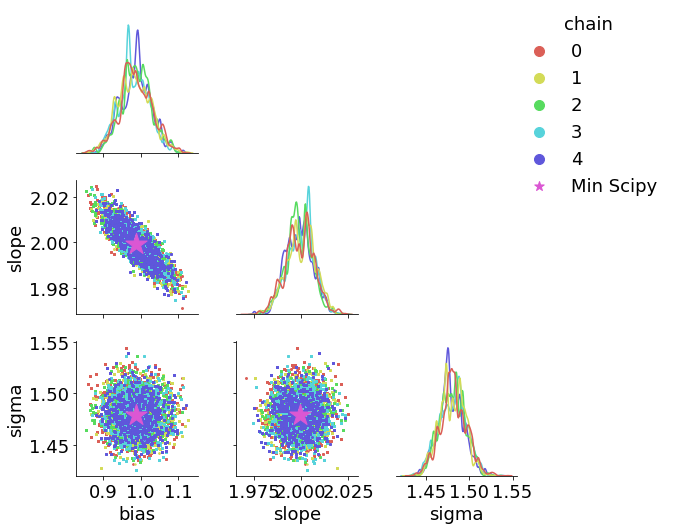

In [444]:
g = sns.PairGrid(full_df_2[full_df_2["chain"].str.fullmatch('0|1|2|3|4|Min Scipy')], 
                 diag_sharey=False,
                 hue="chain",
                 hue_kws={"s": [2]*5+[500], "marker": ["o"]*5+ ["*"]},
                 corner=True, 
                 palette="hls")
g.map_lower(plt.scatter)
g.map_diag(sns.kdeplot,warn_singular=False)
g.add_legend(loc='upper right', ncol=1)
for lh in g._legend.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [100]

In [445]:
all_biass = df_res2["bias"]
all_slopes= df_res2["slope"]
all_sigmas= df_res2["sigma"]
bias_sci = lik_model['x'][0]
slope_sci  = lik_model['x'][1]
sigma_sci = lik_model['x'][2]

In [446]:
from matplotlib.gridspec import GridSpec

In [447]:
def plot_histogram_fig(ax, param, nbins):
    counts, bins = np.histogram(param, bins = nbins)
    plotcounts = np.insert(counts, -1, counts[-1])
    bincentres = (bins[:-1] + bins[1:])/2
    ax.plot(bincentres, counts, 'b')
    
def plot_contour_fig(ax, p1, p2, nbins):
    H, xedges, yedges = np.histogram2d(p1, p2, bins = nbins)
    Z = H.T
    X, Y = np.meshgrid(xedges[:-1], yedges[:-1])
    im = ax.contour(X, Y, Z, levels = 6)
    ax.clabel(im, inline=True, fontsize=4)

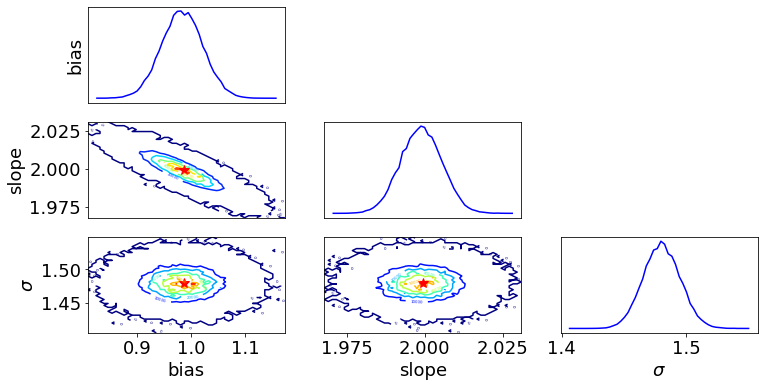

In [448]:
nbins=50
fig = plt.figure(figsize = (12, 6))
gs1 = GridSpec(3, 3, wspace=0.2)
ax00 = fig.add_subplot(gs1[0, 0])
plot_histogram_fig(ax00,all_biass, nbins)
ax00.set_xticks([])
ax00.set_yticks([])
ax00.set_ylabel('bias')

ax10 = fig.add_subplot(gs1[1, 0])
plot_contour_fig(ax10, all_biass, all_slopes, nbins)
ax10.plot(bias_sci,slope_sci,'*r',markersize=10)
ax10.set_xticks([])
ax10.set_ylabel('slope')

ax11 = fig.add_subplot(gs1[1, 1])
plot_histogram_fig(ax11,all_slopes, nbins)
ax11.set_xticks([])
ax11.set_yticks([])

ax20 = fig.add_subplot(gs1[2, 0])
plot_contour_fig(ax20, all_biass, all_sigmas, nbins)
ax20.plot(bias_sci,sigma_sci,'*r',markersize=10)
ax20.set_xlabel('bias')
ax20.set_ylabel('$\sigma$')

ax21 = fig.add_subplot(gs1[2, 1])
plot_contour_fig(ax21, all_slopes, all_sigmas, nbins)
ax21.plot(slope_sci,sigma_sci,'*r',markersize=10)
ax21.set_xlabel('slope')
ax21.set_yticks([])

ax22= fig.add_subplot(gs1[2, 2])
plot_histogram_fig(ax22,all_sigmas, nbins)
ax22.set_yticks([])
ax22.set_xlabel('$\sigma$')

plt.show()

In [449]:
df_res2.describe()

,bias,slope,sigma
count,1.000000e+07,1.000000e+07,1.000000e+07
mean,9.865561e-01,1.999487e+00,1.480271e+00
std,4.186255e-02,7.260820e-03,1.484909e-02
min,8.095948e-01,1.967818e+00,1.404750e+00
25%,9.581979e-01,1.994549e+00,1.470232e+00
50%,9.863743e-01,1.999462e+00,1.480167e+00
75%,1.014891e+00,2.004415e+00,1.490295e+00
max,1.180687e+00,2.032249e+00,1.551535e+00


# Hamiltonian Monte Carlo

## code simple à-la-main

In [576]:
def normal(x,mu,sigma):
    return np.exp(-neg_log_prob(x,mu,sigma))

def neg_log_prob(x,mu,sigma):
#    print(x,mu,sigma)
    tmp= 0.5*((x-mu)/sigma)**2 + 0.5*np.log(2*np.pi*sigma**2)
    return tmp

def gradV(x,mu,sigma):
    return (x-mu)/sigma**2

def HMC(mu=0.0,sigma=1.0,n_steps=10,step_size=0.25,initial_position=0.0,n_spl=10,dump=False):
    # setup
    samples = np.zeros(n_spl)
    samples[0] = initial_position
    momentum_dist = scs.norm(scale=1.0) # gaussian distribution for momentum proposal
    n_accept = 1
    # generate samples
    for i in range(1,n_spl):
        q0 = samples[i-1]
        q1 = q0
        p0 = momentum_dist.rvs()        
        p1 = p0 
        gradV0 = gradV(q0,mu,sigma) #(q0-mu)/(sigma**2) # explicit gradient

        
        # leapfrog integration begin
        for s in range(n_steps): 
            p1 -= step_size*gradV0/2 # as potential energy increases, kinetic energy decreases, half-step
            q1 += step_size*p1     # position increases as function of momentum 
            gradV1 = gradV(q1,mu,sigma) #(q1-mu)/(sigma**2) # update gradient
            if dump:
                print(f"[{i}/{s}] gradV0:{gradV0}, gradV1:{gradV1}")
            p1 -= step_size*gradV1/2 # second half-step "leapfrog" update to momentum    
        # leapfrog integration end        
        #### p1 = -1*p1 #flip momentum for reversibility unnecessary in practice as kinetic term is quadratic in p    

        
        #metropolis-hastings acceptance (negative log version)
        q0_nlp = neg_log_prob(x=q0,mu=mu,sigma=sigma)
        q1_nlp = neg_log_prob(x=q1,mu=mu,sigma=sigma)        

        p0_nlp = neg_log_prob(x=p0,mu=0.,sigma=1.)
        p1_nlp = neg_log_prob(x=p1,mu=0.,sigma=1.)
        
        target = q0_nlp - q1_nlp # P(q1)/P(q0)
        adjustment = p1_nlp - p0_nlp # P(p0)/P(p1)
        r = target + adjustment # [P(q1)*P(p0)]/[P(q0)*P(p1)] 
        
        u = np.log(scs.uniform.rvs())
            
        if dump:
            print(f"[{i}] q0:{q0},q1:{q1}")

        
        if u < r:
            samples[i]=q1
            n_accept += 1
        else:
            samples[i]=q0
    
    return samples, n_accept/n_spl

In [577]:
mu = 0
sigma = 1
Ns = 20_000
samples, acc_rate = HMC(n_steps=120,step_size=0.0171, n_spl=Ns, 
                      initial_position=scs.uniform.rvs(loc=-3,scale=6),
                      mu=mu,sigma=sigma,dump=False) 
print('accept rate:',acc_rate)

accept rate: 0.65915


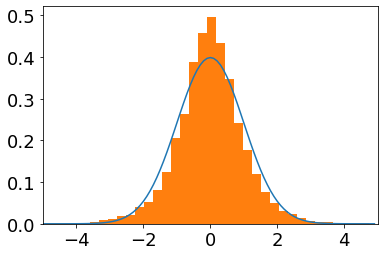

In [578]:
x = np.arange(-mu-5*sigma,mu+5*sigma,sigma/10)
plt.plot(x,normal(x,mu=mu,sigma=sigma))
plt.hist(samples,density=True,bins=50)
plt.xlim([mu-5*sigma,mu+5*sigma])
plt.show()

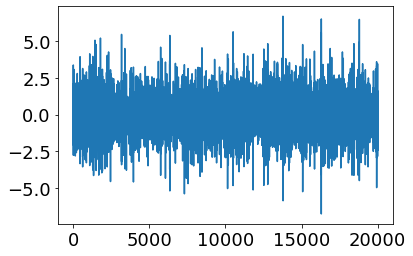

In [574]:
plt.plot(samples)

In [575]:
np.mean(samples),np.std(samples)

(0.005148718923124504, 1.0095824017211457)

# NumPyro Lib.

In [1]:
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import NUTS, HMC, MCMC, init_to_sample

2021-10-02 14:58:43.036188: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.10.2'; dlerror: libcudart.so.10.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 
2021-10-02 14:58:52.535919: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.10.2'; dlerror: libcudart.so.10.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 
2021-10-02 14:58:52.667675: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.10.2'; dlerror: libcudart.so.10.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 


In [4]:
numpyro.__version__

'0.7.2'

## Simple gaussian dist.

In [133]:
class MixtureModel_jax():
    def __init__(self, locs, scales, weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loc = jnp.array([locs]).T
        self.scale = jnp.array([scales]).T
        self.weights = jnp.array([weights]).T
        norm = jnp.sum(self.weights)
        self.weights = self.weights/norm

        self.num_distr = len(locs)

    def logpdf(self, x):
        log_probs = jax.scipy.stats.norm.logpdf(x,loc=self.loc, scale=self.scale)
        return jax.scipy.special.logsumexp(jnp.log(self.weights) + log_probs, axis=0)[0]

    def pdf(self, x):
        probs = jax.scipy.stats.norm.pdf(x,loc=self.loc, scale=self.scale)
        return jnp.dot(self.weights.T,probs).squeeze()




In [141]:
def phi(x):
    return x**2

In [151]:
def autocorr(x,lags):
    '''autocorrelation of a signal wrt lags'''
    mean=x.mean()
    var=np.var(x)
    xp=x-mean

    cf=np.fft.fft(xp)
    sf=cf.conjugate()*cf
    corr=np.fft.ifft(sf).real/var/len(x)

    return corr[:len(lags)]

In [134]:
single_gaussian_model = MixtureModel_jax([0],[1],[1])

In [175]:
Integ_true,_=integrate.quad(lambda x: phi(x)*single_gaussian_model.pdf(x),-7,7)

In [249]:
print("Integ. true: ",Integ_true)

Integ. true:  0.6519999811413002


In [177]:
rng_key = jax.random.PRNGKey(42)
_, rng_key = jax.random.split(rng_key)

kernel = HMC(potential_fn=lambda x: -single_gaussian_model.logpdf(x))  # negative log
num_samples = 1_000_000
n_chains    = 1
mcmc = MCMC(kernel, num_warmup=2_000, num_samples=num_samples, num_chains=n_chains, 
            progress_bar=False)
mcmc.run(rng_key, init_params=jnp.zeros(n_chains))
mcmc.print_summary()
samples_1 = mcmc.get_samples()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
Param:0[0]     -0.00      1.00     -0.00     -1.64      1.65 142899.20      1.00

Number of divergences: 0


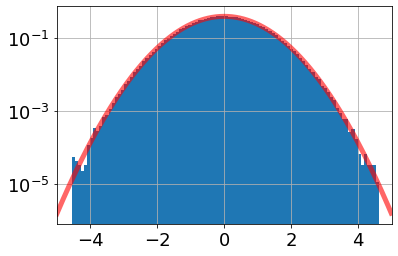

In [178]:
fig = plt.figure()
x_axis = np.arange(-5, 5, 0.01)
#mixture_pdf = jax.vmap(mixture_gaussian_model.pdf)(x_axis)
plt.hist(samples_1.flatten(), bins=100, density=True);
plt.plot(x_axis, single_gaussian_model.pdf(x_axis),'r-', lw=5, alpha=0.6, label='true pdf')
plt.xlim([-5,5])
plt.yscale('log')
plt.grid()
plt.show()

In [252]:
phi_spl1 = phi(samples_1)
Integ_HMC1 = np.mean(phi_spl1)
print(f"Integ_HMC:{Integ_HMC1:.6e}, err. relat: {np.abs(Integ_HMC1-Integ_true)/Integ_true:.6e}, sample size : {len(samples_1.flatten())}")

Integ_HMC:6.761252e-01, err. relat: 3.700187e-02, sample size : 100000


In [181]:
rng_key = jax.random.PRNGKey(42)
_, rng_key = jax.random.split(rng_key)

kernel = NUTS(potential_fn=lambda x: -single_gaussian_model.logpdf(x))  # negative log
num_samples = 1_000_000
n_chains    = 1
mcmc = MCMC(kernel, num_warmup=2_000, num_samples=num_samples, num_chains=n_chains, 
            progress_bar=False)
mcmc.run(rng_key, init_params=jnp.zeros(n_chains))
mcmc.print_summary()
samples_2 = mcmc.get_samples()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
Param:0[0]      0.00      1.00      0.00     -1.64      1.64 379423.92      1.00

Number of divergences: 0


In [184]:
phi_spl2 = phi(samples_2)
Integ_NUTS2 = np.mean(phi_spl2)
print(f"Integ_NUTS:{Integ_NUTS2:.6e}, err. relat: {np.abs(Integ_NUTS2-Integ_true)/Integ_true:.6e}, sample size : {len(samples_2.flatten())}")

Integ_NUTS:9.990863e-01, err. relat: 9.137392e-04, sample size : 1000000


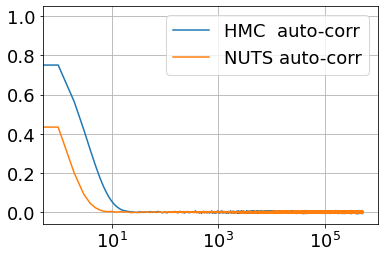

In [189]:
lags=range(len(samples_1.flatten())//2)
plt.plot(lags,autocorr(samples_1.flatten(),lags),label='HMC  auto-corr')
plt.plot(lags,autocorr(samples_2.flatten(),lags),label='NUTS auto-corr')
plt.xscale('log')
plt.grid()
plt.legend()
#plt.xlim([0.1,10**6])
plt.show()

## Mixture of gaussian dist.

In [3]:
mixture_gaussian_model = MixtureModel_jax([0,1.5],[0.5,0.1],[8,2])

In [248]:
Integ_true,_=integrate.quad(lambda x: phi(x)*mixture_gaussian_model.pdf(x),-7,7)

In [176]:
print("Integ. true: ",Integ_true)

Integ. true:  1.000000033372543


In [250]:
rng_key = jax.random.PRNGKey(42)
_, rng_key = jax.random.split(rng_key)

kernel = HMC(potential_fn=lambda x: -mixture_gaussian_model.logpdf(x))  # negative log
num_samples = 100_000
n_chains    = 1
mcmc = MCMC(kernel, num_warmup=2_000, num_samples=num_samples, num_chains=n_chains, 
            progress_bar=False)
mcmc.run(rng_key, init_params=jnp.zeros(n_chains))
mcmc.print_summary()
samples_1 = mcmc.get_samples()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
Param:0[0]      0.32      0.76      0.18     -0.60      1.62    300.83      1.00

Number of divergences: 0


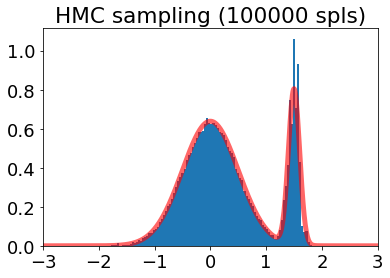

In [251]:
fig = plt.figure()
x_axis = np.arange(-3, 3, 0.01)
#mixture_pdf = jax.vmap(mixture_gaussian_model.pdf)(x_axis)
plt.hist(samples_1.flatten(), bins=100, density=True);
plt.plot(x_axis, mixture_gaussian_model.pdf(x_axis),'r-', lw=5, alpha=0.6, label='true pdf')
plt.xlim([-3,3])
plt.title(f"HMC sampling ({len(samples_1.flatten())} spls)")
plt.show()

In [180]:
phi_spl1 = phi(samples_1)
Integ_HMC1 = np.mean(phi_spl1)
print(f"Integ_HMC:{Integ_HMC1:.6e}, err. relat: {np.abs(Integ_HMC1-Integ_true)/Integ_true:.6e}, sample size : {len(samples_1.flatten())}")

Integ_HMC:9.990271e-01, err. relat: 9.728670e-04, sample size : 1000000


In [253]:
rng_key = jax.random.PRNGKey(42)
_, rng_key = jax.random.split(rng_key)

kernel = NUTS(potential_fn=lambda x: -mixture_gaussian_model.logpdf(x))  # negative log
num_samples = 100_000
n_chains    = 1
mcmc = MCMC(kernel, num_warmup=2_000, num_samples=num_samples, num_chains=n_chains, 
            progress_bar=False)
mcmc.run(rng_key, init_params=jnp.zeros(n_chains))
mcmc.print_summary()
samples_2 = mcmc.get_samples()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
Param:0[0]      0.29      0.74      0.15     -0.62      1.64   2487.31      1.00

Number of divergences: 0


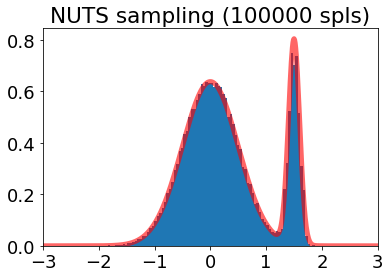

In [262]:
fig = plt.figure()
x_axis = np.arange(-3, 3, 0.01)
#mixture_pdf = jax.vmap(mixture_gaussian_model.pdf)(x_axis)
plt.hist(samples_2.flatten(), bins=100, density=True);
plt.plot(x_axis, mixture_gaussian_model.pdf(x_axis),'r-', lw=5, alpha=0.6, label='true pdf')
plt.xlim([-3,3])
plt.title(f"NUTS sampling ({len(samples_2.flatten())} spls)")
plt.show()

In [255]:
phi_spl2 = phi(samples_2)
Integ_HMC2 = np.mean(phi_spl2)
print(f"Integ_HMC:{Integ_HMC2:.6e}, err. relat: {np.abs(Integ_HMC2-Integ_true)/Integ_true:.6e}, sample size : {len(samples_2.flatten())}")

Integ_HMC:6.316699e-01, err. relat: 3.118109e-02, sample size : 100000


## Multi-chains

In [256]:
rng_key = jax.random.PRNGKey(42)
_, rng_key = jax.random.split(rng_key)

kernel = HMC(potential_fn=lambda x: -mixture_gaussian_model.logpdf(x))  # negative log
num_samples = 10_000
n_chains    = 100
mcmc = MCMC(kernel, num_warmup=2_000, num_samples=num_samples, num_chains=n_chains, 
            progress_bar=False)
mcmc.run(rng_key, init_params=jax.random.uniform(rng_key,shape=(n_chains,),minval=-3,maxval=3))
mcmc.print_summary()
samples_3 = mcmc.get_samples()

/pbs/home/c/campagne/.local/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 100 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(100)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Param:0      0.29      0.74      0.15     -0.62      1.64   5734.42      1.02

Number of divergences: 0


In [258]:
phi_spl3 = phi(samples_3)
Integ_HMC3 = np.mean(phi_spl3)
print(f"Integ_HMC:{Integ_HMC3:.6e}, err. relat: {np.abs(Integ_HMC3-Integ_true)/Integ_true:.6e}, sample size : {len(samples_3.flatten())}")

Integ_HMC:6.396579e-01, err. relat: 1.892959e-02, sample size : 1000000


In [259]:
rng_key = jax.random.PRNGKey(42)
_, rng_key = jax.random.split(rng_key)

kernel = NUTS(potential_fn=lambda x: -mixture_gaussian_model.logpdf(x))  # negative log
num_samples = 10_000
n_chains    = 100
mcmc = MCMC(kernel, num_warmup=2_000, num_samples=num_samples, num_chains=n_chains, 
            progress_bar=False)
mcmc.run(rng_key, init_params=jax.random.uniform(rng_key,shape=(n_chains,),minval=-3,maxval=3))
mcmc.print_summary()
samples_4 = mcmc.get_samples()

/pbs/home/c/campagne/.local/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 100 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(100)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Param:0      0.30      0.75      0.16     -0.62      1.64  19089.36      1.01

Number of divergences: 0


In [261]:
phi_spl4 = phi(samples_4)
Integ_HMC4 = np.mean(phi_spl4)
print(f"Integ_HMC:{Integ_HMC4:.6e}, err. relat: {np.abs(Integ_HMC4-Integ_true)/Integ_true:.6e}, sample size : {len(samples_4.flatten())}")

Integ_HMC:6.516723e-01, err. relat: 5.026171e-04, sample size : 1000000


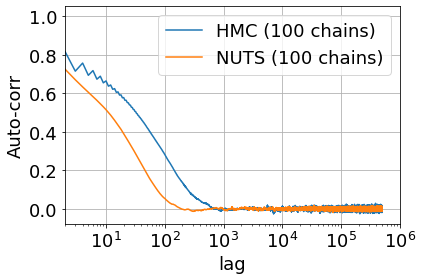

In [267]:
lags=range(len(samples_3.flatten())//2)
plt.plot(lags,autocorr(samples_3.flatten(),lags),label=f'HMC ({n_chains} chains)')
plt.plot(lags,autocorr(samples_4.flatten(),lags),label=f'NUTS ({n_chains} chains)')
plt.xscale('log')
plt.grid()
plt.legend()
plt.xlim([2,10**6])
plt.xlabel('lag')
plt.ylabel('Auto-corr')
plt.show()

# fit de parametres avec NUTS

In [6]:
import corner

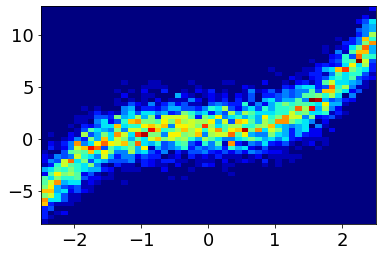

In [7]:
param_true = np.array([1.0, 0.0, 0.2, 0.5, 1.5])
sample_size = 5_000
sigma_e = param_true[4]          # true value of parameter error sigma
random_num_generator = np.random.RandomState(0)
xi = 5*random_num_generator.rand(sample_size)-2.5
e = random_num_generator.normal(0, sigma_e, sample_size)
yi = param_true[0] + param_true[1] * xi + param_true[2] * xi**2 + param_true[3] *xi**3 +  e  
plt.hist2d(xi, yi, bins=50);

In [14]:
#?dist.Uniform

In [3]:
def my_model(Xspls,Yspls):
    a0 = numpyro.sample('a0', dist.Normal(0.,10.))
    a1 = numpyro.sample('a1', dist.Normal(0.,10.))
    a2 = numpyro.sample('a2', dist.Normal(0.,10.))
    a3 = numpyro.sample('a3', dist.Normal(0.,10.))
    sigma = numpyro.sample('sigma', dist.Uniform(low=0.,high=10.))
    mu = a0 + a1*Xspls + a2*Xspls**2 + a3*Xspls**3
    numpyro.sample('obs', dist.Normal(mu, sigma), obs=Yspls)

In [9]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = jax.random.PRNGKey(0)
_, rng_key, rng_key1, rng_key2 = jax.random.split(rng_key, 4)


# Run NUTS.
kernel = NUTS(my_model, init_strategy=init_to_sample())
num_samples = 5_000
n_chains = 1
mcmc = MCMC(kernel, num_warmup=1_000, num_samples=num_samples,  
            num_chains=n_chains,progress_bar=False)
mcmc.run(rng_key, Xspls=xi, Yspls=yi)
mcmc.print_summary()
samples_1 = mcmc.get_samples()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        a0      1.02      0.03      1.02      0.97      1.07   2904.49      1.00
        a1      0.03      0.04      0.03     -0.03      0.09   2701.57      1.00
        a2      0.18      0.01      0.18      0.17      0.20   2864.72      1.00
        a3      0.49      0.01      0.49      0.48      0.51   2752.34      1.00
     sigma      1.48      0.01      1.48      1.46      1.50   3339.37      1.00

Number of divergences: 0


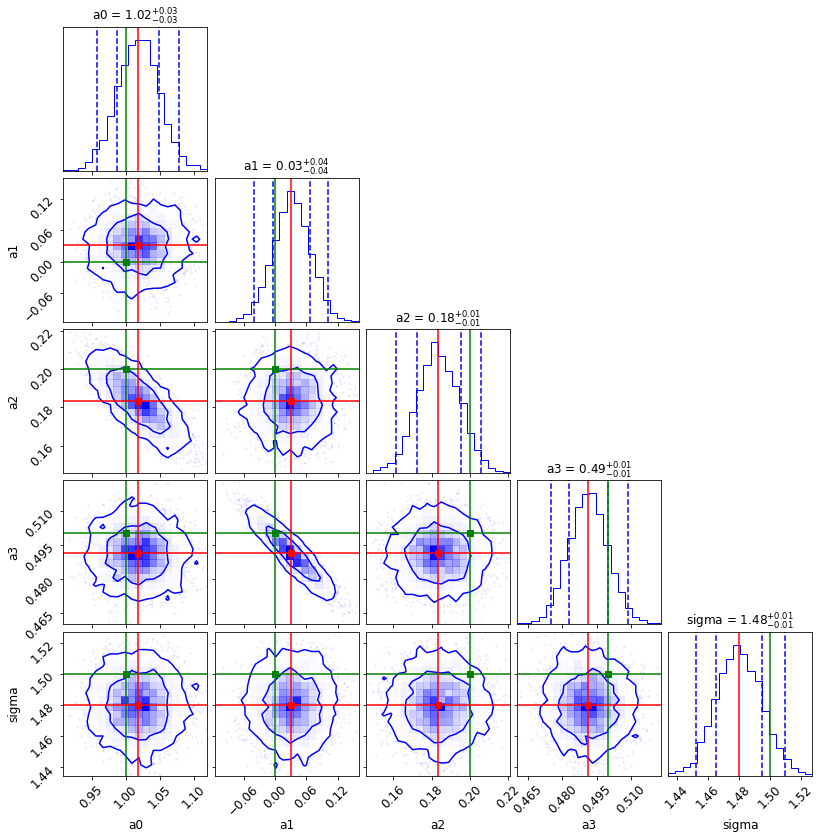

In [10]:
mpl.rcParams['font.size'] = 12
ndim = len(samples_1.keys())
# This is the empirical mean of the sample:
value2 = np.mean(np.array(list(samples_1.values())),axis=1)
#True
value1 = param_true

# Make the base corner plot
# 68% et 95% quantiles 1D et levels in 2D
figure = corner.corner(samples_1,quantiles=(0.025, 0.158655, 0.841345, 0.975), levels=(0.68,0.95), 
                        show_titles=True, title_kwargs={"fontsize": 12}, 
                        truths=param_true, truth_color='g', color='b'
                        );

# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(value2[i], color="r")
    
# Loop over the histograms
for idy in range(ndim):
    for idx in range(idy):
        ax = axes[idy, idx]
        ax.axvline(value2[idx], color="r")
        ax.axhline(value2[idy], color="r")
        ax.plot(value2[idx], value2[idy], "sr")


plt.savefig("toto.png")